In [1]:
import sys
sys.path.append('..')

In [2]:
from tqdm import tqdm
import pandas as pd
import pickle
from scipy.stats import chisquare


In [3]:
from curry.loader import Loader

In [4]:
loader = Loader()

In [5]:
leifi = loader.simple()

In [6]:
leifi.shape

(11667, 7)

In [7]:
leifi.grundwissen_url.nunique()

539

In [8]:
counts_per_state = leifi.land.value_counts().to_frame()
counts_per_state.index = [l.replace('-', ' ').capitalize() for l in counts_per_state.index]
counts_per_state = counts_per_state.reset_index().\
    rename(columns = {'index': 'State', 'land': 'Lesson Count'})
# print(counts_per_state.to_latex())

In [9]:
content_by_url = leifi.groupby('grundwissen_url').content.first()

In [10]:
from curry.clean import Cleaner

In [11]:
cleaner = Cleaner('')

In [14]:
cleaned_contents = [cleaner.clean(c) for c in tqdm(content_by_url)]

100%|███████████████████████████████| 539/539 [02:07<00:00,  4.23it/s]


<AxesSubplot:>

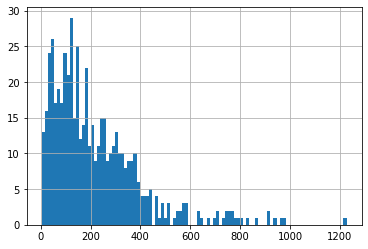

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
tokenizer = vec.build_tokenizer()
word_counts = pd.Series(
    [len(tokenizer(c)) for c in cleaned_contents],
    index=content_by_url.index)
word_counts.hist(bins=100)

In [16]:
word_counts.min(), word_counts.median(), word_counts.max()

(6, 174.0, 1227)

In [17]:
leifi = leifi[
    leifi.grundwissen_url.isin(word_counts[word_counts > 25].index)
]

In [18]:
leifi.shape

(11198, 7)

In [21]:
with open('../data/cache/leifi_enough_text.pkl', 'wb') as f:
    pickle.dump(leifi, f)

### Pre -processing and filtering checkpoint

In [5]:
with open('../data/cache/leifi_enough_text.pkl', 'rb') as f:
    leifi = pickle.load(f)

In [6]:
def agg_land(land_df):
    grade_dist = land_df.klass.value_counts()
    expected = grade_dist.copy()
    expected = grade_dist.mean()
    cs = chisquare(grade_dist, expected)
    return pd.Series({
        'Lowest Grade': land_df.klass.min(),
        'Highest Grade': land_df.klass.max(),
        '# Lessons': land_df.grundwissen_url.nunique(),
        'var': land_df.klass.std(),
        'cs s': cs.statistic,
        'cs p': cs.pvalue
    })

summary = leifi.groupby('land').apply(agg_land)

### Getting Categories

In [186]:
with open('../data/cache/categories_depth_5_v2.pkl', 'rb') as f:
    categories = pickle.load(f)

In [187]:
with open('../data/cache/babelfied.cache', 'rb') as f:
    bab_cache = pickle.load(f)
    
with open('../data/cache/wikified.cache', 'rb') as f:
    wk_cache = pickle.load(f)

In [188]:
wk_urls = []
bab_urls = []

for gu in bab_cache:
    for a in bab_cache[gu]:
        if a.get('DBpediaURL'):
            bab_urls.append(a['DBpediaURL'])
            
for gu in wk_cache:
    for a in wk_cache[gu]['annotations']:
        if a.get('dbPediaIri'):
            wk_urls.append(a['dbPediaIri'])

In [189]:
all_dbpedia_urls = set(bab_urls).union(set(wk_urls))

In [190]:
urls_to_fetch = all_dbpedia_urls.difference(set(categories.keys()))

In [195]:
from curry.km import DBPediaPhysicsResourcesFilter

ImportError: cannot import name 'DBPediaPhysicsResourcesFilter' from 'curry.km' (../curry/km.py)

In [194]:
physics_filter = DBPediaPhysicsResourcesFilter()

NameError: name 'DBPediaPhysicsResourcesFilter' is not defined

### Training

In [7]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [8]:
from curry.model import Trainer, Models

In [9]:
trainer = Trainer('../data/')

In [12]:
test = trainer.train_score(dict(
            land='berlin',
            name='xgbClassifier', 
            vec_type='babelkw',
            vec_type_args=[0.05, True],
            args=[
                10,
                leifi[leifi.land=='berlin'].klass.nunique()
            ]
        ))

In [20]:
job_descs = []
for (vec_type, vec_type_args) in \
    (
    [('babelkw', [t,p]) for t in [0.5, 0.6, 0.7, 0.8, 0.9] for p in [True, False]] + 
     # [('wikikw', [t]) for t in [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09]] +
     [(v, []) for v in [
         # 'kw', 
         # 'st', 
         # 'tfidf'
     ]]):
    for land in leifi.land.unique():#[:2]:
        job_descs.append(dict(
            land=land,
            name='xgbClassifier', 
            vec_type=vec_type,
            vec_type_args=vec_type_args,
            args=[
                10,
                leifi[leifi.land==land].klass.nunique()
            ]
        ))

In [21]:
results = list()

        
for job_desc in tqdm(job_descs):
    result, _ = trainer.train_score(job_desc)
    results.append((job_desc, result))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [10:18<00:00,  3.86s/it]


In [22]:
as_df = []
for (job_desc, result) in results:
    acc = result['accuracy']
    vec_type = job_desc['vec_type']
    vec_spec = ','.join(list(map(str, job_desc['vec_type_args']))) if len(job_desc['vec_type_args']) >= 1 else None
    land = job_desc['land']
    as_df.append((vec_type, vec_spec, land, acc))
    
df = pd.DataFrame(as_df, columns=['vec_type', 'vec_spec', 'land', 'accuracy'])
df.groupby(['vec_type', 'vec_spec']).accuracy.mean()


# df.\
#     pivot(index='land', columns='vec_type').transpose().\
#     style.highlight_max(color='lightgreen').highlight_min(color='red')

vec_type  vec_spec 
babelkw   0.5,False    0.230596
          0.5,True     0.234843
          0.6,False    0.230596
          0.6,True     0.234843
          0.7,False    0.230596
          0.7,True     0.234843
          0.8,False    0.224017
          0.8,True     0.230710
          0.9,False    0.221379
          0.9,True     0.225557
Name: accuracy, dtype: float64

In [17]:
df

,vec_type,vec_spec,land,accuracy
0,babelkw,None,baden-wuerttemberg,0.155845
1,babelkw,None,bayern,0.296504
2,babelkw,None,berlin,0.125592
3,babelkw,None,brandenburg,0.189322
4,babelkw,None,bremen,0.269298
5,babelkw,None,hamburg,0.205426
6,babelkw,None,hessen,0.348571
7,babelkw,None,mecklenburg-vorpommern,0.282913
8,babelkw,None,nordrhein-westfalen,0.189294
9,babelkw,None,saarland,0.346519


In [67]:
sentence_transformer_results= sentence_transformer_results[['land', 'accuracy']].set_index('land')

In [72]:
with open('../results/iwildspaper/sentence_transformer_accuracies_by_state.pkl', 'wb') as f:
    pickle.dump(sentence_transformer_results, f)

In [117]:
with open('../results/iwildspaper/wikikw_accuracies_by_state_threshold.pkl', 'wb') as f:
    pickle.dump(wk.drop(wk.index[80:96]), f)

In [75]:
with open('../results/iwildspaper/babelkw_accuracies_by_state_threshold.pkl', 'wb') as f:
    pickle.dump(babel_results[['vec_spec', 'land', 'accuracy']], f)

### Comparing results

In [118]:
with open('../results/iwildspaper/sentence_transformer_accuracies_by_state.pkl', 'rb') as f:
    st = pickle.load(f)

In [119]:
with open('../results/iwildspaper/wikikw_accuracies_by_state_threshold.pkl', 'rb') as f:
    wk = pickle.load(f)

In [120]:
with open('../results/iwildspaper/babelkw_accuracies_by_state_threshold.pkl', 'rb') as f:
    bl = pickle.load(f)


In [123]:
bl.pivot(index='land', columns='vec_spec').\
    style.highlight_max(color='lightgreen').highlight_min(color='red')

In [124]:
leifi.groupby

,accuracy
land,
baden-wuerttemberg,0.183590
bayern,0.375493
berlin,0.125567
brandenburg,0.207529
bremen,0.305097
hamburg,0.229651
hessen,0.420952
mecklenburg-vorpommern,0.363226
nordrhein-westfalen,0.200252


In [83]:
bl.join(st, on='land', rsuffix='bl', lsuffix='st')

,vec_spec,land,accuracyst,accuracybl
0,0.70,baden-wuerttemberg,0.152011,0.183590
1,0.70,bayern,0.278635,0.375493
2,0.70,berlin,0.126451,0.125567
3,0.70,brandenburg,0.196172,0.207529
4,0.70,bremen,0.253367,0.305097
...,...,...,...,...
155,0.99,sachsen-anhalt,0.218019,0.250073
156,0.99,schleswig-holstein,0.157895,0.212476
157,0.99,thueringen,0.199233,0.253587
158,0.99,niedersachsen,0.159605,0.207627
